<div class="alert alert-success">
    <h1 align="center"> Semantic Segmentation</h1>
    <h1 align="center">Using the Poutyne framework</h1>
    <h3 align="center"><a href="https://poutyne.org/"> Click on this tab for more information</a></h3>




Semantic segmentation refers to the process of linking each pixel in an image 
to a class label. We can think of semantic segmentation as image classification at a pixel level. The image below clarifies the defintion:
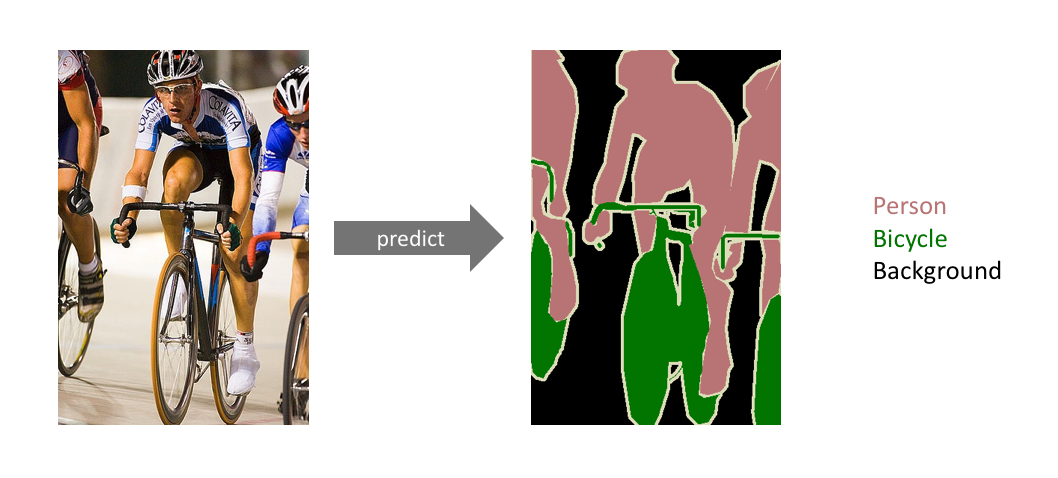

In this example, we are going to use and train a convolutional Unet, inorder to design a network for semantic segmentation. We download and use the VOCSegmentation 2007 dataset for this purpose. This dataset can be easily downloaded from torchvision.datasets.

In [2]:
pip install poutyne    # to install the putyne library

     |████████████████████████████████| 133kB 16.0MB/s 


In [3]:
pip install segmentation-models-pytorch  # this library contains pre-designed networks (mostly unet) for segmentation applications.

     |████████████████████████████████| 71kB 7.7MB/s 
     |████████████████████████████████| 61kB 8.4MB/s 
     |████████████████████████████████| 245kB 34.8MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60963 sha256=26157bfc0d6afedfe63269fa368bbd0beaa422935457cb7f855bd63cbc311eaf
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12421 sha256=283f1c898bf45a11b0903bd5fca9ffbf79b3a4c1d083830046007cd6a4c513b0
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
Successfully built pretrainedmodels efficientnet-pytorch


In [4]:
# if you face a problem about "PIL.version" in google cloab, you can run these codes to fix it.
#pip uninstall pillow
#pip install pillow

In [5]:
# importing the needed libraries for the project

%matplotlib inline
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import math
import os
import segmentation_models_pytorch as smp
import PIL
import cv2


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset,Subset


import torchvision
import torchvision.models as models
import torchvision.transforms as tfms
import torchvision.datasets as datasets
from torchvision.utils import  make_grid,save_image

from poutyne import Model, ModelCheckpoint, CSVLogger


device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print ('The current processor is ...', device)


The current processor is ... cuda


In [51]:
#hyper parameters

learning_rate = 0.001
batch_size = 32
image_size = 224
num_epochs = 5
val_split_rate = 0.2

mean = [0.485, 0.456, 0.406]  # mean of the imagenet dataset for normalizing 
std = [0.229, 0.224, 0.225]  # std of the imagenet dataset for normalizing 

In [52]:
if not os.path.exists('dataset'): os.mkdir('dataset')   # making a directory to download and save the dataset.

transform = tfms.Compose([
    tfms.Resize((image_size, image_size)),  # PIL Image
    tfms.ToTensor(),        # Tensor
    tfms.Normalize(mean, std)
])

trn_dataset = torchvision.datasets.VOCSegmentation('./dataset/', year='2007', download=True, image_set='train', transform=transform)
val_dataset = torchvision.datasets.VOCSegmentation('./dataset/', year='2007', download=True, image_set='val', transform=transform)

Using downloaded and verified file: ./dataset/VOCtrainval_06-Nov-2007.tar
Using downloaded and verified file: ./dataset/VOCtrainval_06-Nov-2007.tar


The VOCSegmentation dataset, downoladed above, contatins numerous images and their segmentation map. However, these are offered as a PIL format and in different sizes. The transformations applied by torchvision.transforms resizes all the images to the tensor of the size (224,224). However, the target image (the PIL segmentation map) should be resized to a tensor with the same size. The function below applies the needed changes and provides the final datasets. 

In [10]:
# to modify the dataset to be proper for the deep learning based segmentation.

class mydataset(Dataset):       
        
    
        def __init__(self, dataset):
            self.dataset = dataset
            
        
        def __getitem__(self, index):
            
            input_image = self.dataset[index][0]
            
            target_image = cv2.resize(np.array(self.dataset[index][1].convert("L")),(224,224)).astype('float32')
            target_image = torch.tensor(target_image).unsqueeze(0)
            
            return input_image, target_image
        def __len__(self):
            
            return len(self.dataset)   


Making the dataset and dataloader, proper for the application:

In [57]:
trn_dataset_new = mydataset(trn_dataset)
val_dataset_new = mydataset(val_dataset)

trn_dataloader = DataLoader(trn_dataset_new, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset_new, batch_size=batch_size, shuffle=False)

A random batch of training dataset is shown below:

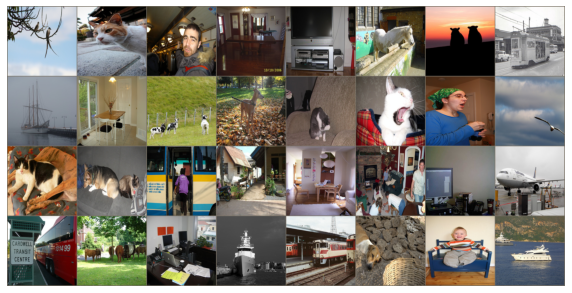

In [62]:
samples = next(iter(trn_dataloader))
inputs = samples[0]
input_grid = make_grid(inputs)

fig = plt.figure(figsize=(10, 10))
input_grid = input_grid.numpy()
input_grid = input_grid.transpose((1, 2, 0)) * std +mean
inp = np.clip(input_grid, 0, 1)
plt.imshow(inp)
plt.axis('off')
plt.show()

The Ground-truth segmentation map for the grid above, is as below (as a gray scale image)

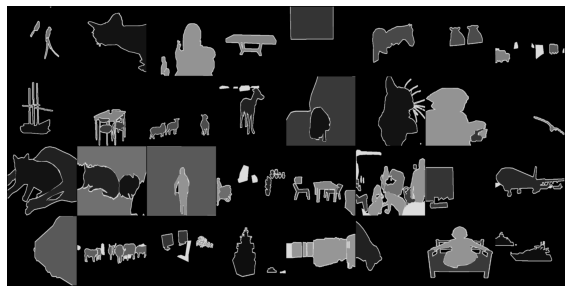

In [63]:

ground_truth = samples[1]
input_grid = make_grid(ground_truth)

fig = plt.figure(figsize=(10, 10))
inp = input_grid.numpy().transpose((1, 2, 0))

plt.imshow(np.uint8(inp))
plt.axis('off')
plt.show()

In [35]:
# specifying loss function
criterion = nn.MSELoss()

# specifying the network
network = smp.Unet('resnet34', encoder_weights='imagenet')

# specifying optimizer
optimizer = optim.Adam (network.parameters(), lr=learning_rate)

You can see the pre-desined imported Res34-Unet elow:

In [17]:
network

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [36]:
#callbacks

save_path = 'saves'

# Creating saving directory 
os.makedirs(save_path, exist_ok=True)

callbacks = [
# Save the latest weights to be able to continue the optimization at the end for more epochs.
ModelCheckpoint(os.path.join(save_path, 'last_weights.ckpt')),

# Save the weights in a new file when the current model is better than all previous models.
ModelCheckpoint(os.path.join(save_path, 'best_weight.ckpt'),
                save_best_only=True, restore_best=True, verbose=True),

# Save the losses for each epoch in a TSV.
CSVLogger(os.path.join(save_path, 'log.tsv'), separator='\t'),
]

In [37]:
# Poutyne Model on GPU
model = Model(network, optimizer, criterion, device=device)

# Train
model.fit_generator(trn_dataloader, val_dataloader, epochs=100, callbacks=callbacks, progress_options={'coloring': False})

Epoch:   1/100 Train steps: 7 Val steps: 7 8.49s loss: 5685.650694 val_loss: 9344.195354
Epoch 1: val_loss improved from inf to 9344.19535, saving file to saves/best_weight.ckpt
Epoch:   2/100 Train steps: 7 Val steps: 7 8.44s loss: 5591.576868 val_loss: 18241.060052
Epoch:   3/100 Train steps: 7 Val steps: 7 8.46s loss: 5529.887821 val_loss: 4605.291793
Epoch 3: val_loss improved from 9344.19535 to 4605.29179, saving file to saves/best_weight.ckpt
Epoch:   4/100 Train steps: 7 Val steps: 7 8.48s loss: 5450.131567 val_loss: 4786.721813
Epoch:   5/100 Train steps: 7 Val steps: 7 8.48s loss: 5377.906902 val_loss: 4718.247689
Epoch:   6/100 Train steps: 7 Val steps: 7 8.48s loss: 5304.863013 val_loss: 4799.598479
Epoch:   7/100 Train steps: 7 Val steps: 7 8.51s loss: 5211.226217 val_loss: 4947.033180
Epoch:   8/100 Train steps: 7 Val steps: 7 8.50s loss: 5140.021316 val_loss: 4845.059380
Epoch:   9/100 Train steps: 7 Val steps: 7 8.52s loss: 5046.775755 val_loss: 4756.288049
Epoch:  10/10

[{'epoch': 1,
  'loss': 5685.65069434061,
  'time': 8.494574389000036,
  'val_loss': 9344.195353763203},
 {'epoch': 2,
  'loss': 5591.5768680846295,
  'time': 8.440742297000043,
  'val_loss': 18241.060051716548},
 {'epoch': 3,
  'loss': 5529.887821471292,
  'time': 8.458180991000063,
  'val_loss': 4605.29179274868},
 {'epoch': 4,
  'loss': 5450.1315672659985,
  'time': 8.475746385999855,
  'val_loss': 4786.721812646713},
 {'epoch': 5,
  'loss': 5377.9069018204245,
  'time': 8.484186092000073,
  'val_loss': 4718.247689260564},
 {'epoch': 6,
  'loss': 5304.8630125784985,
  'time': 8.477482669999972,
  'val_loss': 4799.598479221684},
 {'epoch': 7,
  'loss': 5211.226216731459,
  'time': 8.511674665999863,
  'val_loss': 4947.033180200998},
 {'epoch': 8,
  'loss': 5140.021316163277,
  'time': 8.500831953999977,
  'val_loss': 4845.059380043281},
 {'epoch': 9,
  'loss': 5046.775755083732,
  'time': 8.515756765000106,
  'val_loss': 4756.288049259097},
 {'epoch': 10,
  'loss': 4934.3756074312205

In [38]:
loss, predictions, ground_truth = model.evaluate_generator(val_dataloader, return_pred=True, return_ground_truth=True)

Test steps: 7 3.45s test_loss: 2979.227334                               


We show some of the segmentation results in the image below (gary scale):

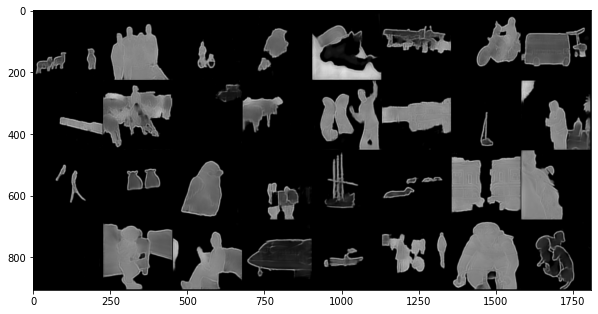

In [39]:
outputs = torch.tensor(model.predict_on_batch(inputs))

output_grid = make_grid(outputs)
fig = plt.figure(figsize=(10, 10))
out = output_grid.numpy().transpose((1, 2, 0))
plt.imshow(np.uint8(out))
plt.show()

To show results in color:

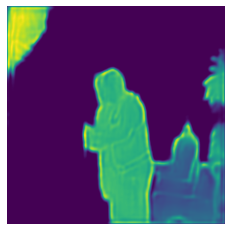

In [50]:
output_sample = outputs[15][0].numpy()
plt.axis('off')
plt.imshow(output_sample)
plt.show()

To get better results you can play with hyper parameters.